# Tarea 1 MCMC Metropolis

In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import distributions

In [2]:
#data=np.load('test_line.npy')
data=np.load('fit_exercise.npy')

In [3]:
#condicioenes para el prior
a_min, a_max=-10, 10
b_min, b_max=-10, 10

def prior(a, b, a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max):
    logp=0
    if a>a_min and a<a_max and b>b_min and b<b_max:
        logp=np.log(1/(a_max-a_min)+1/(b_max-b_min))
    return logp

In [4]:
def Likelihood(a, b, t=data[2], y=data[1], x=data[0]):
    log_like=0
    mu = a + b*x
    log_like += -0.5*np.sum(np.log(2*np.pi*t**2)+(y - mu)**2/(t**2))
    return log_like

In [5]:
def calc_posterior(a, b, t=data[2], y=data[1], x=data[0]): 
    log_posterior=0
    log_posterior = Likelihood(a,b)
    return log_posterior

In [6]:
def metropolis(n_iterations, initial_values, prop_var):
             
    evolution = np.zeros((n_iterations+1, len(initial_values)))  #en esta matriz se guardará los parametros a, b y sigma
    evolution_R= np.zeros((n_iterations+1, len(initial_values))) #se gurdarán todos los valores rechazados y aceptados
    evolution[0] = initial_values     
    evolution_R[0] = initial_values
    current_log_prob = calc_posterior(*evolution[0])  #llamado a la función con entradas como vector de los parametros
    accepted = [0]*len(initial_values)                #contador de cuantas veces se rechazó o se guardó el parametro

    for i in range(n_iterations):      
        current_params = evolution[i]   #paramatros iniciales para los valores que se calcularan 
        for j in range(len(initial_values)):        
            p = evolution[i].copy()     #Realiza una copia de la fila i-esima para calcular nuevamente el postirior y comparar
            theta = np.random.normal (current_params[j], prop_var)    #se crean los numeros aleatorios de a, b y sigma    
            p[j] = theta                             #p contiene los parametros con los que se calculara el nuevo posterior
            proposed_log_prob = calc_posterior(*p)   #se calcula el postitior con los valores de p propuestos
            alpha = proposed_log_prob - current_log_prob #se calcula el ratio de los postiriors
            
            if np.log(np.random.rand()) < alpha:  
                evolution[i+1,j] = theta
                current_log_prob = proposed_log_prob    #se acepta el nuevo prior y se guarda
                accepted[j] += 1                        #contador de veces aceptado
            else:                      
                evolution[i+1,j] = evolution[i,j]
            
            
            evolution_R[i+1,j] = p[j]                   #se guardan todos los valores para graficar
                
    return evolution, evolution_R, accepted

In [15]:
n_iterations=10000
initial_values=[5,4]
prop_des=.06
evolution = metropolis(n_iterations,initial_values,prop_des)
EV=evolution[0]
EV_R=evolution[1]
EV
evolution

(array([[ 5.        ,  4.        ],
        [ 4.93860525,  3.95664969],
        [ 4.84007023,  3.79303626],
        ...,
        [ 5.42049354, -1.09671623],
        [ 5.42049354, -1.09671623],
        [ 5.44898013, -1.09671623]]), array([[ 5.        ,  4.        ],
        [ 4.93860525,  3.95664969],
        [ 4.84007023,  3.79303626],
        ...,
        [ 5.47411859, -1.12105361],
        [ 5.54004869, -1.16151957],
        [ 5.44898013, -1.02478915]]), [5538, 1401])

In [16]:
#graficando los datos con la solución obtenida
ysol=np.zeros(len(data[0]))
for i in range (len(data[0])):
    ysol[i]=EV[-1,0]+EV[-1,1]*data[0,i]

Text(0,0.5,'frecuancia de a')

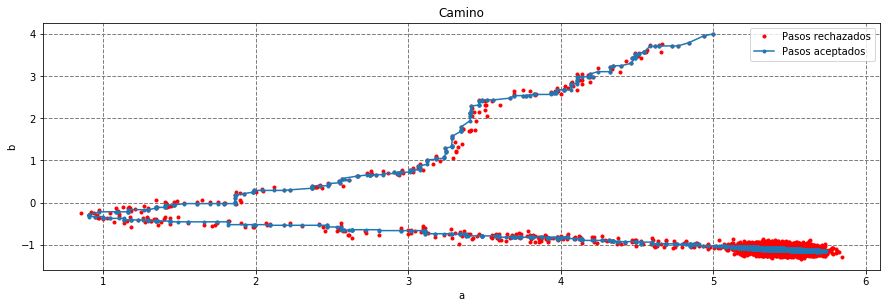

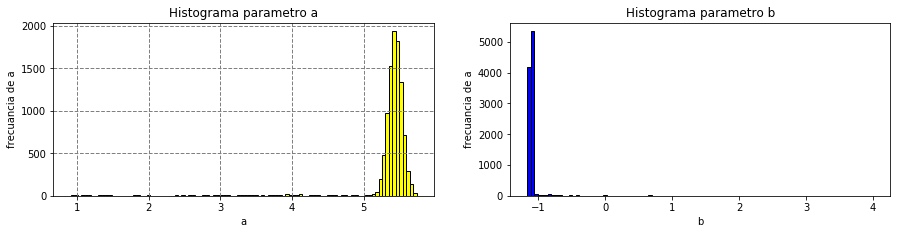

In [17]:
#solución en la misma grafica (comparacion de solución numerica y anañítica)
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
plt.plot(EV_R[:,0],EV_R[:,1],'.', color='red')
plt.plot(EV[:,0],EV[:,1],'.-')
plt.title("Camino")
plt.xlabel("a")              
plt.ylabel("b") 
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
plt.legend(('Pasos rechazados', 'Pasos aceptados'), loc='upper right')

plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
plt.hist(EV[:,0],100,color='yellow',edgecolor='black',label='parametro b');
plt.title("Histograma parametro a")
plt.xlabel('a')              
plt.ylabel('frecuancia de a')               
plt.grid(color = '0.5', linestyle = '--', linewidth = 1)

plt.subplot(2,2,2)
plt.hist(EV[:,1],100,color='blue',edgecolor='black',label='parametro a');
plt.title("Histograma parametro b")
plt.xlabel("b")              
plt.ylabel("frecuancia de a") 



## Comparando con Maximum Likelihood Method

Supongamos que se tienen n mediciones ($x_1, y_1\pm \sigma_1$; $x_2, y_2\pm \sigma_2$; $x_n, y_n\pm \sigma_n$) si se conoce la función de distribución entonces se conoce una relación funcional de $y=f(x,\alpha, \beta, \gamma, ...)$ donde $\alpha, \beta, \gamma, ...$ son parametros 

Likelihood Function es $$L=\prod_{i=1}^{n} f(x_i,\alpha, \beta, ...)$$

Usando un likelihood gausiano para una linea recta


$$L=\prod_{i=1}^{n} \frac{1}{\sigma_i\sqrt{2\pi}}exp({-\frac{(y_i- \lambda (x_i , \theta ))^2}{2\sigma_i^2}})$$
$$L=\prod_{i=1}^{n} \frac{1}{\sigma_i\sqrt{2\pi}}exp({-\frac{(y_i-\alpha-\beta x_i)^2}{2\sigma_i^2}})$$

$$ ln ({L}(x_i,y_i|\vec{\theta}))= \sum_{i}ln(\frac{1}{\sigma_i\sqrt{2\pi}}) -\frac{(y_i-\alpha-\beta x_i)^2 }{2\sigma_i^2}$$


Para maximizar la función obtenemos 

$$\frac{\partial}{\partial\alpha}ln(L)=\sum_{i}\frac{y_i-\alpha -\beta x_1}{\sigma_i^2}=0$$

$$\frac{\partial}{\partial\beta}ln(L)=\sum_{i}\frac{(y_i-\alpha -\beta x_1)x_i}{\sigma_i^2}=0$$

o bien

$$\sum_{i}\frac{y_i}{\sigma_i^2}=\alpha\sum_{i}\frac{1}{\sigma_i^2}+\beta\sum_{i}\frac{x_i}{\sigma_i^2}$$

$$\sum_{i}\frac{y_ix_i}{\sigma_i^2}=\alpha\sum_{i}\frac{x_i}{\sigma_i^2}+\beta\sum_{i}\frac{x_i^2}{\sigma_i^2}$$

El sistema a resolver es de la forma
$$\begin{pmatrix}
\sum_{i}\frac{y_i}{\sigma_i^2}\\
\sum_{i}\frac{y_ix_i}{\sigma_i^2}\\
\end{pmatrix}
\begin{pmatrix}
\sum_{i}\frac{1}{\sigma_i^2} & \sum_{i}\frac{x_i}{\sigma_i^2} \\
\sum_{i}\frac{x_i}{\sigma_i^2} & \sum_{i}\frac{x_i^2}{\sigma_i^2} \\
\end{pmatrix}=
\begin{pmatrix}
\alpha\\
\beta\\
\end{pmatrix}
$$

de los datos sabemos que A[0]-> x; A[1]->y, A[2]->error, a->b0, b->b1

In [18]:
X=data[0,]
Y=data[1,]
Sigma=data[2,]
Sigma_sqrt=Sigma
Sigma_sq=Sigma**2   

In [19]:
S=[np.sum(Y/Sigma_sq),np.sum((Y*X)/Sigma_sq)]
M=[(np.sum(1/Sigma_sq),np.sum(X/Sigma_sq)),(np.sum(X/Sigma_sq),np.sum((X**2)/Sigma_sq))]
M_inv = np.linalg.inv(M)
solucion=M_inv @ S
y=np.zeros(len(X))

In [20]:
#usando los valores de X tenemos
for i in range (len(X)):
    y[i]=solucion[0]+solucion[1]*X[i]
solucion

array([ 5.44055525, -1.1040757 ])

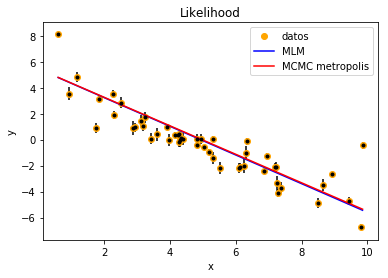

In [21]:
plt.plot(data[0],data[1], 'o', color='orange')
plt.plot(X,y, color='blue')
plt.plot(data[0],ysol, color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(data[0],data[1],data[2], fmt='.k')
plt.title('Likelihood')
plt.legend(('datos','MLM', 'MCMC metropolis'), loc='upper right')
plt.show()

![](bayes.jpg)